In [1]:
from moseq2_detectron_extract.model.model import MoseqDatasetMapper
import os

from moseq2_detectron_extract.model.config import (add_dataset_cfg,
                                                   get_base_config,
                                                   load_config)
from moseq2_detectron_extract.io.annot import (
    augment_annotations_with_rotation, default_keypoint_names,
    get_dataset_statistics, read_annotations, register_dataset_metadata,
    register_datasets, replace_data_path_in_annotations, show_dataset_info,
    validate_annotations)


from albumentations.augmentations.transforms import GaussNoise, RandomFog 
from moseq2_detectron_extract.model.augmentations import Albumentations, DoughnutNoiseAugmentation
from detectron2.data.transforms.augmentation_impl import RandomBrightness, RandomContrast, RandomRotation


from detectron2.data import build_detection_train_loader
import itertools
import matplotlib.pyplot as plt
import numpy as np
from detectron2.data import transforms as T
import random

In [2]:
model_dir = r'C:\Users\thackray\git\moseq2-detectron-extract\notebooks\models\2021-09-28_big_model\2021-10-05T13-56_51'
annot_file = [
    "C:\\Users\\thackray\\moseq-detectron-data\\2021-09-15_sci-dataset-big-annotated-keypoints-masks\\project-3-at-2021-09-16-21-07-30920741.json",
    "C:\\Users\\thackray\\moseq-detectron-data\\moseq-mask-keypoints-annot\\result.json",
]
replace_data_path = [
    ("/data/local-files/?d=Moseq-SCI-Detectron/images/", "C:\\Users\\thackray\\moseq-detectron-data\\2021-09-15_sci-dataset-big-annotated-keypoints-masks\\sci-dataset\\images\\"),
    ("images/", "C:\\Users\\thackray\\moseq-detectron-data\\moseq-mask-keypoints-annot\\images\\"),
    ("E:\\moseq_raw_data\\unet_testing\\multi-dataset\\from_cluster\\images\\", "C:\\Users\\thackray\\moseq-detectron-data\\moseq-mask-keypoints-annot\\images\\")
]
                

cfg = load_config(os.path.join(model_dir, "config.yaml"))


intensity_scale = (100/255)

annotations = []
for anot_f in annot_file:
    annot = read_annotations(anot_f, default_keypoint_names, mask_format=cfg.INPUT.MASK_FORMAT, rescale=intensity_scale)
    annotations.extend(annot)

for search, replace in replace_data_path:
    replace_data_path_in_annotations(annotations, search, replace)

validate_annotations(annotations)
#annotations = augment_annotations_with_rotation(annotations)
print('Dataset information:')
show_dataset_info(annotations)
register_datasets(annotations, default_keypoint_names)

Dataset information:
Number of Items:  2575
Image size range:
 -> Width: 244 - 250 px
 -> Height: 240 - 250 px
Instance Bounding Box Sizes:
 -> Width: 8.28 - 92.82; mean 40.95 ± 18.54 stdev
 -> Height: 7.78 - 94.96; mean 41.82 ± 19.39 stdev
 -> Ratio: 1.00 - 5.61; mean 1.81 ± 0.74 stdev


In [3]:
augs = [
    RandomRotation([0, 360], expand=True, sample_style='range'),
    RandomBrightness(0.8, 1.2),
    RandomContrast(0.8, 1.2),
    Albumentations(GaussNoise()),
    DoughnutNoiseAugmentation(),
]
loader = build_detection_train_loader(cfg, mapper=MoseqDatasetMapper(cfg, is_train=True, augmentations=augs))

In [4]:
items = list(itertools.islice(loader, 1))[0]

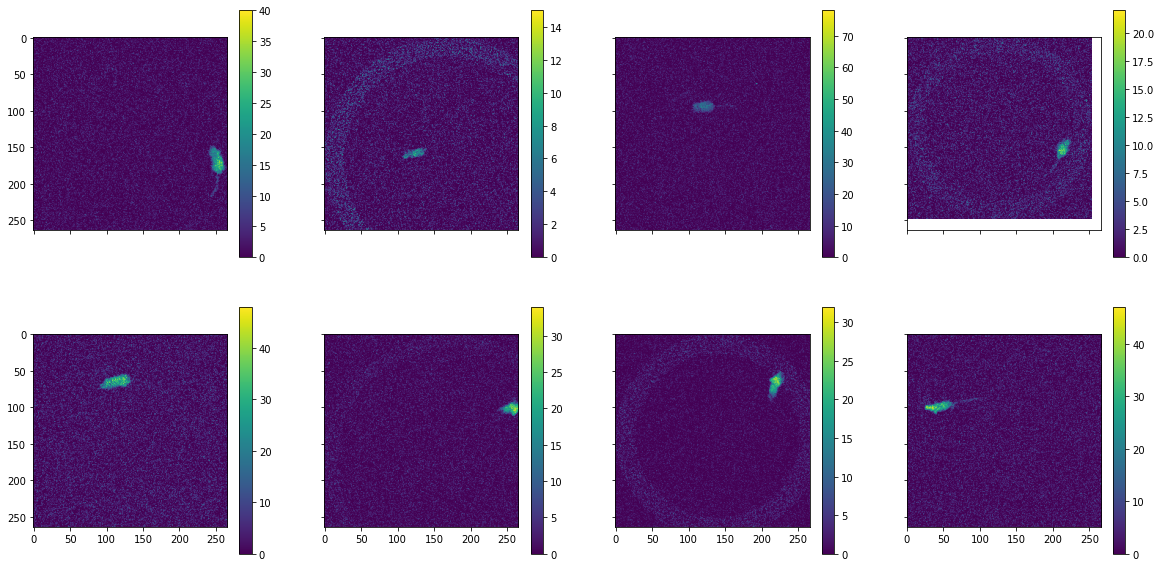

In [5]:
num_images = cfg.SOLVER.IMS_PER_BATCH
vmin = None
vmax = None

fig, axs = plt.subplots(2, num_images // 2, figsize=(20,10), sharex=True, sharey=True)
axs = list(itertools.chain(*axs))

for i, data in enumerate(items):
    im = axs[i].imshow(np.squeeze(data['image'].numpy()), vmin=vmin, vmax=vmax)
    plt.colorbar(im, ax=axs[i])


In [5]:
items

[{'file_name': 'C:\\Users\\thackray\\moseq-detectron-data\\2021-09-15_sci-dataset-big-annotated-keypoints-masks\\sci-dataset\\images\\session_20200819121932_depth_20263.png',
  'width': 246,
  'height': 242,
  'image_id': 498,
  'rescale_intensity': 0.39215686274509803,
  'image': tensor([[[ 9,  0,  0,  ...,  8, 12,  8],
           [ 1,  0,  0,  ...,  0,  5,  0],
           [ 1, 14,  0,  ...,  0,  0,  2],
           ...,
           [ 0,  5,  2,  ...,  0,  2,  0],
           [ 0,  0,  0,  ..., 11,  0,  6],
           [14,  0,  0,  ...,  8,  0,  0]]], dtype=torch.uint8),
  'instances': Instances(num_instances=1, image_height=344, image_width=344, fields=[gt_boxes: Boxes(tensor([[208.4355, 158.9516, 269.4761, 216.8758]])), gt_classes: tensor([0]), gt_masks: PolygonMasks(num_instances=1), gt_keypoints: Keypoints(num_instances=1)])},
 {'file_name': 'C:\\Users\\thackray\\moseq-detectron-data\\moseq-mask-keypoints-annot\\images\\1763.png',
  'width': 248,
  'height': 246,
  'image_id': 1039,


In [3]:
class DoughnutNoiseAugmentation(T.Augmentation):
    def __init__(self, mu: float=0, var_limit=(10.0, 50.0), thickness=(0, 30), weight=0.5, always_apply=False, p=0.5):
        self.mu = mu
        self.thickness = self.validate_range_arg('thickness', thickness)
        self.var_limit = self.validate_range_arg('var_limit', var_limit)
        self.weight = weight
        self.always_apply = always_apply
        self.p_application = p
        
    def validate_range_arg(self, param_name: str, value):
        if isinstance(value, (tuple, list)):
            if value[0] < 0:
                raise ValueError(f"Lower {param_name} should be non negative.")
            if value[1] < 0:
                raise ValueError(f"Upper {param_name} should be non negative.")
            return value
        elif isinstance(var_limit, (int, float)):
            if value < 0:
                raise ValueError(f"{param_name} should be non negative.")

            return (0, value)
        else:
            raise TypeError(
                "Expected var_limit type to be one of (int, float, tuple[int|float], list[int|float]), got {}".format(type(value))
            )
    
    def get_transform(self, image):
        if (random.random() < self.p_application) or self.always_apply:
            # select random values for some parameters
            thickness = random.uniform(self.thickness[0], self.thickness[1])
            var = random.uniform(self.var_limit[0], self.var_limit[1])
            sigma = var ** 0.5
            random_state = np.random.RandomState(random.randint(0, 2 ** 32 - 1))

            xx, yy = np.mgrid[:image.shape[0], :image.shape[1]]
            r_outer = np.max(image.shape[:2]) // 2
            r_inner = r_outer - thickness
            cx = image.shape[0] // 2
            cy = image.shape[1] // 2
            circle = (xx - cx) ** 2 + (yy - cy) ** 2
            donut = np.logical_and(circle < r_outer ** 2, circle > r_inner ** 2)

            im = np.zeros(shape=image.shape[:2], dtype=float)
            im[donut] = random_state.normal(self.mu, sigma, size=np.count_nonzero(donut))
            return T.BlendTransform(im[:,:,None], self.weight, 1-self.weight)
        else:
            return T.NoOpTransform()

124


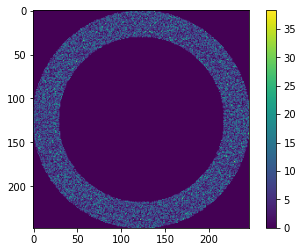

In [61]:

width = 248
height = 246
xx, yy = np.mgrid[:width, :height]
r_outer = width // 2
print(r_outer)
r_inner = r_outer - 30
cx = width // 2
cy = height // 2
circle = (xx - cx) ** 2 + (yy - cy) ** 2
donut = np.logical_and(circle < r_outer ** 2, circle > r_inner ** 2)
        
im = np.zeros(shape=(width, height), dtype=float)
im[donut] = np.abs(np.random.normal(0, 10, size=np.count_nonzero(donut)))
plt.imshow(im)
plt.colorbar()